In [1]:
#--Import Necessary Library--
import sys
import math
import numpy as np
from scipy import special
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd

# 1. HF STO-nG, apakah perlu di ralat?
R = 1.6 a.u<br>
alpha dan coefficient untuk primitive gaussian dari https://www.basissetexchange.org

In [2]:
# HF STO-nG
Vee = [0.6620037441341327, 0.6533831353864948, 0.6545069801998092]
T = [1.085544019466817, 1.1403847798313982, 1.1796724544828034]
Vne = [-3.3464203547086058, -3.4998212898024064, -3.5623204054932462]
Vnn = [0.625, 0.625, 0.625]
Total_Energy = [-0.973872591107656, -1.081053374584514, -1.1031409708106332]

data = {
    "id": ["HF STO-1G", "HF STO-2G", "HF STO-3G"],
    "electron repulsion": Vee,
    "kinetic": T,
    "nuclear-electron attraction": Vne,
    "nuclear repulsion": Vnn,
    "total energy": Total_Energy
}

df = pd.DataFrame(data, index=data["id"])
df = df.drop(columns=["id"])
df.transpose()

,HF STO-1G,HF STO-2G,HF STO-3G
electron repulsion,0.662004,0.653383,0.654507
kinetic,1.085544,1.140385,1.179672
nuclear-electron attraction,-3.346420,-3.499821,-3.562320
nuclear repulsion,0.625000,0.625000,0.625000
total energy,-0.973873,-1.081053,-1.103141


alpha dan coefficient untuk primitive gaussian dari Bapak

In [3]:
# revisi HF STO-nG
one_G = [0.5630522997284593, 0.764710102521208, -2.9145721801560507, 0.625, -0.9618097779063841]
two_G = [0.5593235956604841, 0.7923492041848993, -3.0485516660843768, 0.625, -1.071878866238993]
three_G = [0.5549681236521616, 0.7964105056578553, -3.0701425054056033, 0.625, -1.0937638760955863]
index = ["electron repulsion", "kinetic", "nuclear-electron attraction", "nuclear repulsion", "total energy"]

data = {
    "index": index, 
    "HF STO-1G": one_G,
    "HF STO-2G": two_G,
    "HF STO-3G": three_G
}

df = pd.DataFrame(data, index=data["index"])
df = df.drop(columns=["index"])
df

,HF STO-1G,HF STO-2G,HF STO-3G
electron repulsion,0.563052,0.559324,0.554968
kinetic,0.764710,0.792349,0.796411
nuclear-electron attraction,-2.914572,-3.048552,-3.070143
nuclear repulsion,0.625000,0.625000,0.625000
total energy,-0.961810,-1.071879,-1.093764


# 2. HF-STO dari paper Dewar

Saya membuat versi python dari spreadsheet Sdr Fiqri

# 3. STO-10G

In [4]:
class primitive_gaussian():

    def __init__(self, alpha, coeff, coordinates):
        
        self.alpha = alpha
        self.coeff = coeff
        self.coordinates = np.array(coordinates)
        self.A = ( 2.0 * alpha / math.pi ) ** 0.75

In [5]:
def overlap(molecule):
    
    nbasis = len(molecule)
    
    S = np.zeros([nbasis, nbasis])
    
    for i in range(nbasis):
        for j in range(nbasis):
            
            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):
                    
                    N = molecule[i][k].A * molecule[j][l].A
                    p = molecule[i][k].alpha + molecule[j][l].alpha
                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q,Q)
                    
                    S[i,j] += N * molecule[i][k].coeff * molecule[j][l].coeff * math.exp(-q*Q2) * (math.pi/p)**(3/2) 
    
    return S

In [6]:
def kinetic(molecule):
    
    nbasis = len(molecule)
    
    T = np.zeros([nbasis, nbasis])
    
    for i in range(nbasis):
        for j in range(nbasis):

            nprimitives_i = len(molecule[i])
            nprimitives_j = len(molecule[j])
            
            for k in range(nprimitives_i):
                for l in range(nprimitives_j):

                    N = molecule[i][k].A * molecule[j][l].A
                    cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                    p   = molecule[i][k].alpha + molecule[j][l].alpha
                    P   = molecule[i][k].alpha*molecule[i][k].coordinates +  molecule[j][l].alpha*molecule[j][l].coordinates
                    Pp  = P/p
                    PG  = Pp - molecule[j][l].coordinates
                    PGx2 = PG[0]*PG[0]
                    PGy2 = PG[1]*PG[1]
                    PGz2 = PG[2]*PG[2]

                    q = molecule[i][k].alpha * molecule[j][l].alpha / p
                    Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                    Q2 = np.dot(Q,Q)
                
                    s = math.exp(-q*Q2) * (math.pi/p)**(3/2) * N * cacb
                    
                    T[i,j] += 3.0 * molecule[j][l].alpha * s
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGx2 + 0.5/p)
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGy2 + 0.5/p)
                    T[i,j] -= 2.0 * molecule[j][l].alpha * molecule[j][l].alpha * s * (PGz2 + 0.5/p)

    return T       

In [7]:
def boys(x,n):
    if x == 0:
        return 1.0/(2*n+1)
    else:
        return special.gammainc(n+0.5,x) * special.gamma(n+0.5) * (1.0/(2*x**(n+0.5)))
    
def electron_nuclear_attraction(molecule, Z):
    
    natoms = len(Z)
    nbasis = len(molecule)   
    
    coordinates = []
    for i in range(nbasis):
        nprimitives_i = len(molecule[i])
        for j in range(nprimitives_i):
            coordinates.append(molecule[i][j].coordinates )

    coordinates = np.array(coordinates)
    coordinates = np.unique(coordinates, axis=0)
    
    V_ne = np.zeros([nbasis, nbasis])
 
    for atom in range(natoms):
        for i in range(nbasis):
            for j in range(nbasis):

                nprimitives_i = len(molecule[i])
                nprimitives_j = len(molecule[j])
            
                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):

                        N = molecule[i][k].A * molecule[j][l].A
                        cacb = molecule[i][k].coeff * molecule[j][l].coeff
                    
                        p   = molecule[i][k].alpha + molecule[j][l].alpha
                        P   = molecule[i][k].alpha*molecule[i][k].coordinates +  molecule[j][l].alpha*molecule[j][l].coordinates
                        Pp  = P/p
                        
                        PG  = P/p - coordinates[atom]
                        
                        PG2 = np.dot(PG,PG)

                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][l].coordinates
                        Q2 = np.dot(Q,Q)
                    
                        V_ne[i,j] +=  N * cacb * -Z[atom] * (2.0*math.pi/p) * math.exp(-q*Q2) * boys(p*PG2,0)                                     
                    

    return V_ne           

In [8]:
def electron_electron_repulsion(molecule):
    
    nbasis = len(molecule)   
    
    V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])
 
    for i in range(nbasis):
        for j in range(nbasis):
            for k in range(nbasis):
                for l in range(nbasis):

                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])
                    nprimitives_k = len(molecule[k])
                    nprimitives_l = len(molecule[l])
            
                    for ii in range(nprimitives_i):
                        for jj in range(nprimitives_j):
                            for kk in range(nprimitives_k):
                                for ll in range(nprimitives_l):

                                    N        = molecule[i][ii].A * molecule[j][jj].A * molecule[k][kk].A * molecule[l][ll].A
                                    cicjckcl = molecule[i][ii].coeff * molecule[j][jj].coeff * \
                                               molecule[k][kk].coeff * molecule[l][ll].coeff
                    
                                    pij = molecule[i][ii].alpha + molecule[j][jj].alpha
                                    pkl = molecule[k][kk].alpha + molecule[l][ll].alpha
                         
                                    Pij = molecule[i][ii].alpha*molecule[i][ii].coordinates +\
                                          molecule[j][jj].alpha*molecule[j][jj].coordinates
                                    Pkl = molecule[k][kk].alpha*molecule[k][kk].coordinates +\
                                          molecule[l][ll].alpha*molecule[l][ll].coordinates
                            
                                    Ppij = Pij/pij
                                    Ppkl = Pkl/pkl
                                    
                                    PpijPpkl  = Ppij - Ppkl
                                    PpijPpkl2 = np.dot(PpijPpkl,PpijPpkl)
                                    denom     = 1.0/pij + 1.0/pkl
                            
                                    qij = molecule[i][ii].alpha * molecule[j][jj].alpha / pij
                                    qkl = molecule[k][kk].alpha * molecule[l][ll].alpha / pkl

                                    Qij = molecule[i][ii].coordinates - molecule[j][jj].coordinates
                                    Qkl = molecule[k][kk].coordinates - molecule[l][ll].coordinates
                                    
                                    Q2ij = np.dot(Qij,Qij)
                                    Q2kl = np.dot(Qkl,Qkl)
                                    
                                    term1 = 2.0*math.pi*math.pi/(pij*pkl)
                                    term2 = math.sqrt(  math.pi/(pij+pkl) )
                                    term3 = math.exp(-qij*Q2ij) 
                                    term4 = math.exp(-qkl*Q2kl)
                                                      
                                    V_ee[i,j,k,l] += N * cicjckcl * term1 * term2 * term3 * term4 * boys(PpijPpkl2/denom,0)  # 3 more                               
                    

    return V_ee           

In [9]:
def nuclear_nuclear_repulsion_energy(atom_coords, zlist):
    
    assert (len(atom_coords) == len(zlist))
    natoms = len(zlist)
    E_NN = 0
    for i in range(natoms):
        Zi = zlist[i]
        for j in range(natoms):
            if j > i:
                Zj = zlist[j]
                Rijx = atom_coords[i][0] - atom_coords[j][0]
                Rijy = atom_coords[i][1] - atom_coords[j][1]
                Rijz = atom_coords[i][2] - atom_coords[j][2]
                Rijx_squared = Rijx*Rijx
                Rijy_squared = Rijy*Rijy
                Rijz_squared = Rijz*Rijz             
                Rij = math.sqrt(Rijx_squared + Rijy_squared + Rijz_squared)      
                E_NN += (Zi*Zj)/Rij
                
    return E_NN    

In [10]:
# scf
def compute_G(density_matrix, Vee):
    nbasis_functions = density_matrix.shape[0]
    G = np.zeros((nbasis_functions, nbasis_functions))
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            for k in range(nbasis_functions):
                for l in range(nbasis_functions):
                    density = density_matrix[k,l]
                    J = Vee[i,j,k,l]
                    K = Vee[i,l,k,j]
                    G[i,j] += density*(J-0.5*K)
    return G

def compute_density_matrix(mos):
    nbasis_functions = mos.shape[0]
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    # P = occ*CC_dagger
    occupation = 2.0
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            # mo is (natomic_orbtials x nMOs)
            for oo in range(number_occupied_orbitals):
                C = mos[i, oo]
                C_dagger = mos[j, oo]
                density_matrix[i,j] += occupation * C * C_dagger 
    return density_matrix

def compute_electronic_energy_expectation_value(density_matrix, T, Vne, G):
    Hcore = T + Vne
    Hcore_ = 0
    electronic_energy = 0.0
    G_ = 0
    T_ = 0
    Vne_ = 0
    nbasis_functions = density_matrix.shape[0]
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            electronic_energy += density_matrix[i,j] * (Hcore[i,j] + 0.5*G[i,j])
            Hcore_ += density_matrix[i,j] * (Hcore[i,j])
            G_ += density_matrix[i,j] * 0.5*G[i,j]
            T_ += density_matrix[i,j] * T[i,j]
            Vne_ += density_matrix[i,j] * Vne[i,j]
#     print(G_, T_, Vne_)
            
    return electronic_energy

def scf_cycle(molecular_terms, scf_parameters, molecule):
    
    S, T, Vne, G = molecular_terms
    tolerance, max_scf_steps = scf_parameters
    electronic_energy = 0.0
    nbasis_functions = len(molecule)
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    
    # 1. Enter into the SCF cycles
    for scf_step in range(max_scf_steps):
        
        electronic_energy_old = electronic_energy
        
        # 2. Compute the 2 electron term, and add it to the 1 electron term
        G = compute_G(density_matrix, Vee)
        
        # 3. Form F, make S unit, then get eigenvalues and eigenvectors - transform eigenvectors back (w.o unitS)
        F = T + Vne + G
        # S^{-1/2}
        S_inverse = linalg.inv(S)
        S_inverse_sqrt = linalg.sqrtm(S_inverse)
        # S^{-1/2} F S^{-1/2}
        F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
        eigenvalues, eigenvectors = linalg.eigh(F_unitS)
        mos = np.dot(S_inverse_sqrt, eigenvectors)

        # 4. Form new density matrix using MOs
        density_matrix = compute_density_matrix(mos)
        
        # 5. Compute electronic_energy expectation value
        electronic_energy = compute_electronic_energy_expectation_value(density_matrix, T, Vne, G)
        
        # 6. Check convergence
        if abs(electronic_energy-electronic_energy_old) < tolerance:
            return electronic_energy
    
    print("Warning: Convergence not met")
    return electronic_energy

In [11]:
# create many H2 molecules
distances = np.arange(0.5,  6.1, 0.1)  # in unit = bohr (a.u of position)
# distances = [1.6]
molecule_coordinates = [ [[0.0, 0.0, 0.0], [0.0, 0.0, distance]] for distance in distances]

In [12]:
# prep STO-3G, STO-10G, and STO
coeff = [ 0.00775, 0.20267, 0.41300, 0.31252, 0.14249, 0.04899, 0.01380, 0.00318, 0.00058, 0.00007]
alpha = [0.0285649, 0.0812406, 0.190537, 0.463925, 1.2025518, 3.379649, 10.60720, 38.65163, 173.5822, 1170.498]

zeta = 1
x = np.linspace(-5,5,num=1000)
r = abs(x)

STO_10G = 0
for i, j in zip(alpha, coeff):
    STO_10G += (j*(2*i/np.pi)**(0.75)*np.exp(-i*r**2))

alpha = [0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00]
coeff = [0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00]
STO_3G = 0
for i, j in zip(alpha, coeff):
    STO_3G += (j*(2*i/np.pi)**(0.75)*np.exp(-i*r**2))
    
STO = ((zeta**3)/np.pi)**0.5 * np.exp(-zeta*r)
STO_ = ((1.24**3)/np.pi)**0.5 * np.exp(-1.24*r)

In [13]:
total_energies1 = []
for molecule_coordinate in molecule_coordinates:
    H1_pg1a = primitive_gaussian(0.28294212, 1, molecule_coordinate[0])
    H2_pg1a = primitive_gaussian(0.28294212, 1, molecule_coordinate[1])
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a]
    H2_1s = [H2_pg1a]
    molecule = [H1_1s, H2_1s]
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
#     print("Vnn", Enn, "\nTotal Energy", total_energy)
    total_energies1.append(total_energy)

In [14]:
total_energies2 = []
for molecule_coordinate in molecule_coordinates:
    H1_pg1a = primitive_gaussian(0.201527, 0.82123, molecule_coordinate[0])
    H1_pg1b = primitive_gaussian(1.33248, 0.27441, molecule_coordinate[0])
    H2_pg1a = primitive_gaussian(0.201527, 0.82123, molecule_coordinate[1])
    H2_pg1b = primitive_gaussian(1.33248, 0.27441, molecule_coordinate[1])
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a, H1_pg1b]
    H2_1s = [H2_pg1a, H2_pg1b]
    molecule = [H1_1s, H2_1s]
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
#     print("Vnn", Enn, "\nTotal Energy", total_energy)
    total_energies2.append(total_energy)

In [15]:
total_energies3 = []
for molecule_coordinate in molecule_coordinates:
    H1_pg1a = primitive_gaussian(0.151374, 0.64767, molecule_coordinate[0])
    H1_pg1b = primitive_gaussian(0.681277, 0.40789, molecule_coordinate[0])
    H1_pg1c = primitive_gaussian(4.500380, 0.07048, molecule_coordinate[0])
    H2_pg1a = primitive_gaussian(0.151374, 0.64767, molecule_coordinate[1])
    H2_pg1b = primitive_gaussian(0.681277, 0.40789, molecule_coordinate[1])
    H2_pg1c = primitive_gaussian(4.500380, 0.07048, molecule_coordinate[1])
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c]
    H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c]
    molecule = [H1_1s, H2_1s]
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
#     print("Vnn", Enn, "\nTotal Energy", total_energy)
    total_energies3.append(total_energy)

In [16]:
total_energies10 = []
for molecule_coordinate in molecule_coordinates:
    H1_pg1a = primitive_gaussian(0.0285649, 0.00775, molecule_coordinate[0])
    H1_pg1b = primitive_gaussian(0.0812406, 0.20267, molecule_coordinate[0])
    H1_pg1c = primitive_gaussian(0.190537, 0.41300, molecule_coordinate[0])
    H1_pg1d = primitive_gaussian(0.463925, 0.31252, molecule_coordinate[0])
    H1_pg1e = primitive_gaussian(1.2025518, 0.14249, molecule_coordinate[0])
    H1_pg1f = primitive_gaussian(3.379649, 0.04899, molecule_coordinate[0])
    H1_pg1g = primitive_gaussian(10.60720, 0.01380, molecule_coordinate[0])
    H1_pg1h = primitive_gaussian(38.65163, 0.00318, molecule_coordinate[0])
    H1_pg1i = primitive_gaussian(173.5822, 0.00058, molecule_coordinate[0])
    H1_pg1j = primitive_gaussian(1170.498, 0.00007, molecule_coordinate[0])
    
    H2_pg1a = primitive_gaussian(0.0285649, 0.00775, molecule_coordinate[1])
    H2_pg1b = primitive_gaussian(0.0812406, 0.20267, molecule_coordinate[1])
    H2_pg1c = primitive_gaussian(0.190537, 0.41300, molecule_coordinate[1])
    H2_pg1d = primitive_gaussian(0.463925, 0.31252, molecule_coordinate[1])
    H2_pg1e = primitive_gaussian(1.2025518, 0.14249, molecule_coordinate[1])
    H2_pg1f = primitive_gaussian(3.379649, 0.04899, molecule_coordinate[1])
    H2_pg1g = primitive_gaussian(10.60720, 0.01380, molecule_coordinate[1])
    H2_pg1h = primitive_gaussian(38.65163, 0.00318, molecule_coordinate[1])
    H2_pg1i = primitive_gaussian(173.5822, 0.00058, molecule_coordinate[1])
    H2_pg1j = primitive_gaussian(1170.498, 0.00007, molecule_coordinate[1])
    number_occupied_orbitals = 1
    zlist = [1.0, 1.0]
    atom_coords = [np.array(molecule_coordinate[0]), np.array(molecule_coordinate[1])]
    H1_1s = [H1_pg1a, H1_pg1b, H1_pg1c, H1_pg1d, H1_pg1e, H1_pg1f, H1_pg1g, H1_pg1h, H1_pg1i, H1_pg1j]
    H2_1s = [H2_pg1a, H2_pg1b, H2_pg1c, H2_pg1d, H2_pg1e, H2_pg1f, H2_pg1g, H2_pg1h, H2_pg1i, H2_pg1j]
    molecule = [H1_1s, H2_1s]
    S = overlap(molecule)
    T = kinetic(molecule)
    Vne = electron_nuclear_attraction(molecule, [1.0, 1.0])
    Vee = electron_electron_repulsion(molecule)
    Enn = nuclear_nuclear_repulsion_energy(atom_coords, zlist)
    molecular_terms = [S, T, Vne, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
    total_energies10.append(total_energy) 

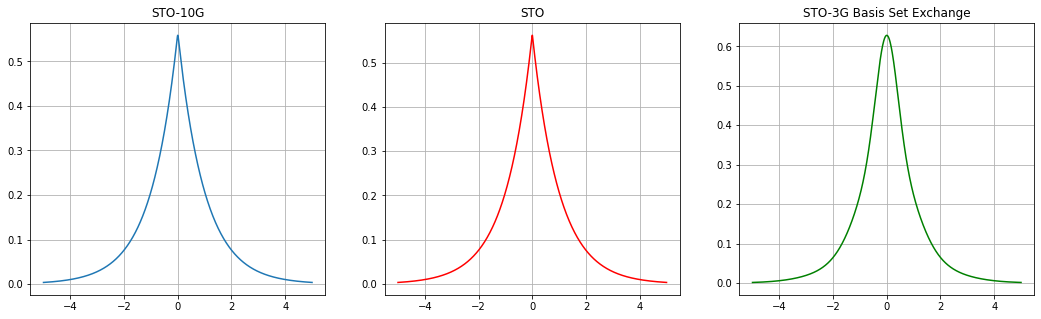

In [17]:
# plot STO-10G and STO
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.plot(x, STO_10G); plt.grid(); plt.title("STO-10G")
plt.subplot(132)
plt.plot(x, STO, '-r'); plt.grid(); plt.title("STO")
plt.subplot(133)
plt.plot(x, STO_3G, '-g'); plt.grid(); plt.title("STO-3G Basis Set Exchange")
plt.show()

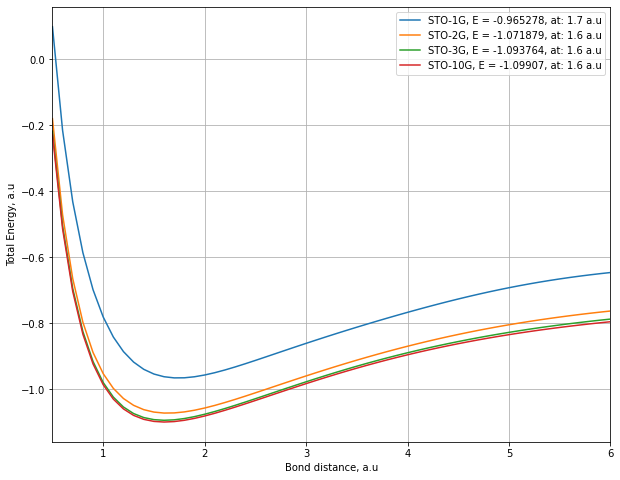

In [18]:
# plot h2 total energy for every bond distance
plt.figure(figsize=(10,8))
plt.xlabel("Bond distance, a.u")
plt.ylabel("Total Energy, a.u")
plt.plot(np.array(distances), total_energies1, label=f"STO-1G, E = {round(min(total_energies1), 6)}, at: {round(molecule_coordinates[total_energies1.index(min(total_energies1))][1][-1], 1)} a.u")
plt.plot(np.array(distances), total_energies2, label=f"STO-2G, E = {round(min(total_energies2), 6)}, at: {round(molecule_coordinates[total_energies2.index(min(total_energies2))][1][-1], 1)} a.u")
plt.plot(np.array(distances), total_energies3, label=f"STO-3G, E = {round(min(total_energies3), 6)}, at: {round(molecule_coordinates[total_energies3.index(min(total_energies3))][1][-1], 1)} a.u")
plt.plot(np.array(distances), total_energies10, label=f"STO-10G, E = {round(min(total_energies10), 6)}, at: {round(molecule_coordinates[total_energies10.index(min(total_energies10))][1][-1], 1)} a.u")
plt.xlim(0.5, 6); plt.legend(); plt.grid()
plt.show()